# T1Dexi Data Processing Analysis

We need to make some small changes / exploration: 
- Why are the dates in 2031? Are we correctly getting local date time? 
   - Check time of day for different meal labels
   - Check blood glucose patterns throughout the day
   - If necessary, count meals for different times of day
- Go deeper into understanding whether the insulin doses and basal rates are processed correctly
- Do the same for other data types (meals, carbs, heartrate, exercise...)
- Insulin type information?


In [24]:
import os
import subprocess
import zipfile
import zipfile_deflate64
import datetime
import random
import xport
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [6]:
!pip install zipfile-deflate64

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for zipfile-deflate64: filename=zipfile_deflate64-0.2.0-cp311-cp311-macosx_11_0_arm64.whl size=18467 sha256=901f84a60f102ec33e42a978637c80df21d713b6aa1267aef3fb403e373ac4ec
  Stored in directory: /Users/miriamk.wolff/Library/Caches/pip/wheels/19/cc/32/e51b420eff4d53b88d2fd4d8673f193f4eef200ef417a1ec0d
Successfully built zipfile-deflate64

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Inspect zip file
zip_path = '../unprocessed_data/t1dexi/T1DEXI.zip'
import zipfile
import os

# Check if the file exists
if not os.path.exists(zip_path):
    print(f"Error: File '{zip_path}' does not exist.")
else:
    print(f"Inspecting contents of '{zip_path}'...")

    # Open the .zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_file:
        # List all files in the .zip archive
        file_list = zip_file.namelist()
        print("Files in the .zip archive:")
        for file_name in file_list:
            print(f"- {file_name}")

Inspecting contents of '../unprocessed_data/t1dexi/T1DEXI.zip'...
Files in the .zip archive:
- T1DEXI - DATA FOR UPLOAD/CM.xpt
- T1DEXI - DATA FOR UPLOAD/defineXML.html
- T1DEXI - DATA FOR UPLOAD/DI.xpt
- T1DEXI - DATA FOR UPLOAD/DM.xpt
- T1DEXI - DATA FOR UPLOAD/DX.xpt
- T1DEXI - DATA FOR UPLOAD/FA.xpt
- T1DEXI - DATA FOR UPLOAD/FACM.xpt
- T1DEXI - DATA FOR UPLOAD/FADX.xpt
- T1DEXI - DATA FOR UPLOAD/FAMLPD.xpt
- T1DEXI - DATA FOR UPLOAD/FAMLPI.xpt
- T1DEXI - DATA FOR UPLOAD/FAMLPM.xpt
- T1DEXI - DATA FOR UPLOAD/LB.xpt
- T1DEXI - DATA FOR UPLOAD/ML.xpt
- T1DEXI - DATA FOR UPLOAD/NV.xpt
- T1DEXI - DATA FOR UPLOAD/PR.xpt
- T1DEXI - DATA FOR UPLOAD/QS.xpt
- T1DEXI - DATA FOR UPLOAD/README.txt
- T1DEXI - DATA FOR UPLOAD/RP.xpt
- T1DEXI - DATA FOR UPLOAD/SC.xpt
- T1DEXI - DATA FOR UPLOAD/SUPPDM.xpt
- T1DEXI - DATA FOR UPLOAD/T1DEXI ACRF_15Sept2022.pdf
- T1DEXI - DATA FOR UPLOAD/T1DEXI SDRG_03Mar2023.pdf
- T1DEXI - DATA FOR UPLOAD/TI DEXI Protocol 8-25-20_V6.0.pdf
- T1DEXI - DATA FOR UPLOAD/

In [22]:
def save_files_from_zip(zip_path, file_types=['.pdf', '.html']):    
    with zipfile.ZipFile(zip_path, 'r') as zip_file:
        # Find files in the zip archive that match the specified types (pdf or html)
        matched_files = [f for f in zip_file.namelist() if any(f.endswith(ext) for ext in file_types)]
        
        if not matched_files:
            raise FileNotFoundError(f"No files with extensions {file_types} found in the zip archive.")
        
        # Loop through the matched files and save them locally
        for matched_file in matched_files:
            local_file_path = os.path.basename(matched_file)
            
            # Save the file to the output directory
            with zip_file.open(matched_file) as extracted_file:
                with open(local_file_path, 'wb') as local_file:
                    local_file.write(extracted_file.read())
                    print(f"Saved {matched_file} to {local_file_path}")
save_files_from_zip(zip_path, file_types=['.pdf', '.html'])


Saved T1DEXI - DATA FOR UPLOAD/defineXML.html to defineXML.html
Saved T1DEXI - DATA FOR UPLOAD/T1DEXI ACRF_15Sept2022.pdf to T1DEXI ACRF_15Sept2022.pdf
Saved T1DEXI - DATA FOR UPLOAD/T1DEXI SDRG_03Mar2023.pdf to T1DEXI SDRG_03Mar2023.pdf
Saved T1DEXI - DATA FOR UPLOAD/TI DEXI Protocol 8-25-20_V6.0.pdf to TI DEXI Protocol 8-25-20_V6.0.pdf


In [16]:
def get_df_from_zip_deflate_64(zip_path, file_name):
    with zipfile_deflate64.ZipFile(zip_path, 'r') as zip_file:
        # Find the file in the archive that ends with the specified file_name
        matched_files = [f for f in zip_file.namelist() if f.endswith(file_name)]
        if not matched_files:
            raise FileNotFoundError(f"No file ending with '{file_name}' found in the zip archive.")
        
        # Use the first match (if multiple matches, refine criteria as needed)
        matched_file = matched_files[0]

        # Read the .xpt file directly from the zip
        with zip_file.open(matched_file) as xpt_file:
            df = xport.to_dataframe(xpt_file)  # Load the .xpt file into a DataFrame
    return df


In [17]:
glucose_file = 'LB.xpt'

In [18]:
df_glucose = get_df_from_zip_deflate_64(zip_path, glucose_file)

In [19]:
df_glucose.head()

,STUDYID,DOMAIN,USUBJID,LBSEQ,LBTESTCD,LBTEST,LBCAT,LBORRES,LBORRESU,LBSTRESC,LBSTRESN,LBSTRESU,LBDTC,LBSOURCE,LBCRNORD,LBSETTNG,LBTMINT
0,T1DEXI,LB,1,1.0,GLUC,Glucose,CGM,115.0,mg/dL,115,115.0,mg/dL,1.904774e+09,,,,
1,T1DEXI,LB,1,2.0,GLUC,Glucose,CGM,109.0,mg/dL,109,109.0,mg/dL,1.904775e+09,,,,
2,T1DEXI,LB,1,3.0,GLUC,Glucose,CGM,105.0,mg/dL,105,105.0,mg/dL,1.904775e+09,,,,
3,T1DEXI,LB,1,4.0,GLUC,Glucose,CGM,106.0,mg/dL,106,106.0,mg/dL,1.904775e+09,,,,
4,T1DEXI,LB,1,5.0,GLUC,Glucose,CGM,110.0,mg/dL,110,110.0,mg/dL,1.904776e+09,,,,


### Analyze Date Formatting

In [23]:
df_glucose['LBDTC']

Variable
0          1.904774e+09
1          1.904775e+09
2          1.904775e+09
3          1.904775e+09
4          1.904776e+09
               ...     
3785750    1.934236e+09
3785751    1.934236e+09
3785752    1.934236e+09
3785753    1.934237e+09
3785754    1.929658e+09
Name: LBDTC, Length: 3785755, dtype: float64
label: , width: 8, vtype: 1, format: B8601DT0., informat: 

In [27]:
# The .xpt format is used for SAS Transport files, and these can sometimes store dates and times in specific numeric formats.
# In SAS, datetime values are often represented as the number of seconds since January 1, 1960 (not the Unix epoch of January 1, 1970).
# This might be the reason why dates were in 2030
sas_epoch = datetime.datetime(1960, 1, 1)
# Convert SAS datetime to pandas datetime
df_glucose['sas_datetime'] = pd.to_datetime(df_glucose['LBDTC'], unit='s', origin=sas_epoch)
df_glucose.head()

,STUDYID,DOMAIN,USUBJID,LBSEQ,LBTESTCD,LBTEST,LBCAT,LBORRES,LBORRESU,LBSTRESC,LBSTRESN,LBSTRESU,LBDTC,LBSOURCE,LBCRNORD,LBSETTNG,LBTMINT,sas_datetime
0,T1DEXI,LB,1,1.0,GLUC,Glucose,CGM,115.0,mg/dL,115,115.0,mg/dL,1.904774e+09,,,,,2020-05-11 00:01:17
1,T1DEXI,LB,1,2.0,GLUC,Glucose,CGM,109.0,mg/dL,109,109.0,mg/dL,1.904775e+09,,,,,2020-05-11 00:06:17
2,T1DEXI,LB,1,3.0,GLUC,Glucose,CGM,105.0,mg/dL,105,105.0,mg/dL,1.904775e+09,,,,,2020-05-11 00:11:17
3,T1DEXI,LB,1,4.0,GLUC,Glucose,CGM,106.0,mg/dL,106,106.0,mg/dL,1.904775e+09,,,,,2020-05-11 00:16:18
4,T1DEXI,LB,1,5.0,GLUC,Glucose,CGM,110.0,mg/dL,110,110.0,mg/dL,1.904776e+09,,,,,2020-05-11 00:21:18


In [29]:
df_glucose['LBDTC'] = pd.to_datetime(df_glucose['LBDTC'], unit='s')
df_glucose['LBSTRESN'] = pd.to_numeric(df_glucose['LBSTRESN'], errors='coerce')
df_glucose.rename(columns={'LBSTRESN': 'CGM', 'LBDTC': 'date', 'USUBJID': 'id'}, inplace=True)
df_glucose = df_glucose[df_glucose['LBSTRESU'] == 'mg/dL']
df_glucose = df_glucose[['id', 'CGM', 'date']]
df_glucose.set_index('date', inplace=True)
df_glucose.head()

,id,CGM
date,,
2030-05-12 00:01:17,1,115.0
2030-05-12 00:06:17,1,109.0
2030-05-12 00:11:17,1,105.0
2030-05-12 00:16:18,1,106.0
2030-05-12 00:21:18,1,110.0


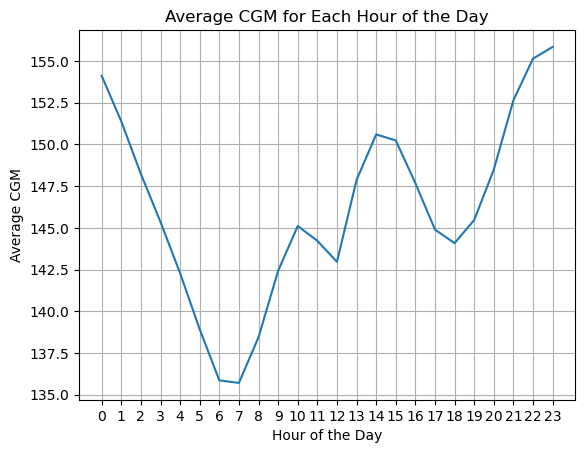

In [31]:
# Extract the hour from the index and group by it
df_glucose['hour'] = df_glucose.index.hour
hourly_avg = df_glucose.groupby('hour')['CGM'].mean()

# Plot the average CGM for each hour of the day
plt.plot(hourly_avg.index, hourly_avg.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Average CGM')
plt.title('Average CGM for Each Hour of the Day')
plt.xticks(range(24))  # Show all 24 hours on the x-axis
plt.grid(True)
plt.show()

The results are very typical. Morning blood glucose is good, while throughout the day, and especially after dinner time, they increase.